# Métodos iterativos de solución

La solución del sistema $Ax = b$ por métodos directos bajo ciertas condiciones de tamaño y dispersión llega a ser ineficiente cuando se utilizan algoritmos directos.
Los métodos iterativos para resolver el sistema $Ax = b$ se basan en la _iteración de punto fijo_, comienzan con un punto inicial $x_0$ con el cual se estima un nuevo vector en cada paso, convegiendo a la solución.

## Método de Jacobi

In [1]:
using LinearAlgebra
using SparseArrays
using BenchmarkTools
using CUDA
using CUDA.CUSPARSE
using Plots 

#=using Pkg
Pkg.add("LaTeXStrings")
using LaTeXStrings=#

## Secuencial

La idea clásica de aplicar un método iterativo es por medio de la descomposición aditiva de la matriz de coeficientes del sistema: $A = M-N$ de tal forma que $Mx = Nx+b$. El sistema se convierte en una iteración de punto fijo. Si $M$ es el vector formado por la diagonal de $A$, está será la iteración de **Jacobi**. 

$A = M-N$ Oscar, ¿entonces donde quedaron las matrices ¿$L, D, U$?

Este ejemplo muestra una forma iterativa de esta manera: $Mx = Nx + b => x = \frac{Nx + b}{M}$ ¿Esto es lo mismo que usar las matrices $L, D, U$?

Sí, es lo mismo porque $N = U + L$ y $M = D$ y va a hacer algo como $x = M^{-1}(Nx + b) = D^{-1}[(U+L)x +b]$



In [94]:
function jacobi(dims=20000,iter=50)
    m = dims;
    A = sprandn(m,m,0.01) + m/100*sparse(Matrix{Float64}(I, m, m));
    b = ones(m);
    dA = diag(A);
    N = - triu(A,1) - tril(A,-1);
    x = 0*b;
    normres = [];
    for k = 1:iter
        x = (N*x + b)./dA;
        normres = [normres;norm(b-A*x)];
    end
    return normres
end

jacobi (generic function with 3 methods)

In [95]:
@btime jacobi(25000,300)

  7.959 s (22870 allocations: 5.97 GiB)


300-element Array{Any,1}:
 9.994640614179193
 0.6319183334029663
 0.040130219180854715
 0.0025292869053844054
 0.00016060604567319923
 1.013133959310986e-5
 6.449947736038827e-7
 4.091490361404914e-8
 2.5954787759128863e-9
 1.6299003068210257e-10
 1.0336534757723842e-11
 6.576317409434562e-13
 9.949370038983664e-14
 ⋮
 8.988467358948953e-14
 8.98861134507083e-14
 8.988261660487947e-14
 8.988618201495293e-14
 8.988467358948953e-14
 8.98861134507083e-14
 8.988261660487947e-14
 8.988618201495293e-14
 8.988467358948953e-14
 8.98861134507083e-14
 8.988261660487947e-14
 8.988618201495293e-14

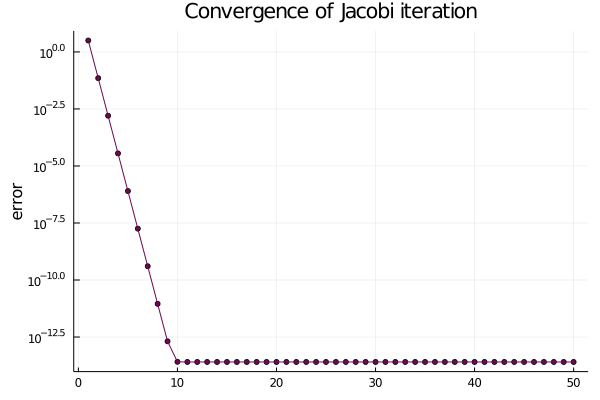

In [14]:
scatter(normres, markersize=3, c="#6b0851", leg=false)
plot!(normres, color="#6b0851")
plot!(yaxis = ("error", :log10))
plot!(title="Convergence of Jacobi iteration")

Los métodos iterativos tienen un precio: la convergencia del método depende en fuerte medida de la matriz $A$, tanto como el método elegido.

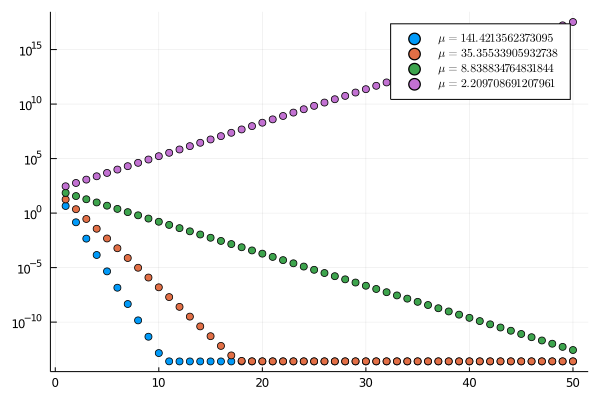

In [16]:
m = 20000
μ = sqrt(m)
p = plot()
for i = 1:4
    A = sprandn(m,m,0.001) + μ * sparse(Matrix{Float64}(I, m, m));
    b = ones(m);
    dA = diag(A);
    N = - triu(A,1) - tril(A,-1);
    x = 0*b;
    normres = [];
    for k = 1:50
        x = (N*x + b)./dA;
        normres = [normres; norm(b-A*x)];
    end
    #display(scatter!(normres, leg=false))
    #println(normres)
    #normres = [; scatter(normres, leg=false)]
    a = 3
    p = scatter!(normres, label = "\$\\mu=$μ\$")
    p = plot!(yaxis = (:log10))
    #p = plot!(μ, label=L"$\mu=$")
    #p = scatter!(normres)
    #display(p)
    #scatter!(normres)
    μ = μ/4
end
display(p)

## CUDA

In [110]:
function bm(iter,N,x,b,dA)
    normres = []
    for k = 1:iter
        x = (N*x + b)./dA
        normres = [normres;norm(b-A*x)]
    end
end

bm (generic function with 2 methods)

In [112]:
iter = 50
m = 25000
A = sprandn(Float32,m,m,0.01) + Float32(m/100)*sparse(Matrix(1f0I, m, m))
b = CUDA.ones(Float32,m)
dA = diag(A)
dA = CuArray(dA)
N = - triu(A,1) - tril(A,-1)
A = CuSparseMatrixCSR(A)
N = CuSparseMatrixCSR(N)
x = CUDA.zeros(Float32, size(b))
@btime bm(iter,N,x,b,dA)

  17.571 ms (9551 allocations: 226.14 KiB)


In [113]:
iter = 50
m = 25000
A = sprandn(m,m,0.01) + m/100*sparse(Matrix{Float64}(I, m, m))
b = ones(m)
dA = diag(A)
N = - triu(A,1) - tril(A,-1)
x = 0*b
@btime bm(iter,N,x,b,dA)

  890.751 ms (3986 allocations: 152.17 MiB)


In [100]:
function jacobiGPU(iter=50,dim=20000)
    m = dim;
    A = sprandn(Float32,m,m,0.01) + Float32(m/100)*sparse(Matrix(1f0I, m, m));
    b = CUDA.ones(Float32,m);
    dA = diag(A);
    dA = CuArray(dA)
    N = - triu(A,1) - tril(A,-1);
    A = CuSparseMatrixCSR(A)
    N = CuSparseMatrixCSR(N)
    x = CUDA.zeros(Float32, size(b))
    normres = [];
    for k = 1:iter
        x = (N*x + b)./dA
        normres = [normres;norm(b-A*x)]
    end
    return normres
end

jacobiGPU (generic function with 3 methods)

In [99]:
@btime jacobiGPU(300,25000)

  1.300 s (30195 allocations: 2.69 GiB)


Any[]

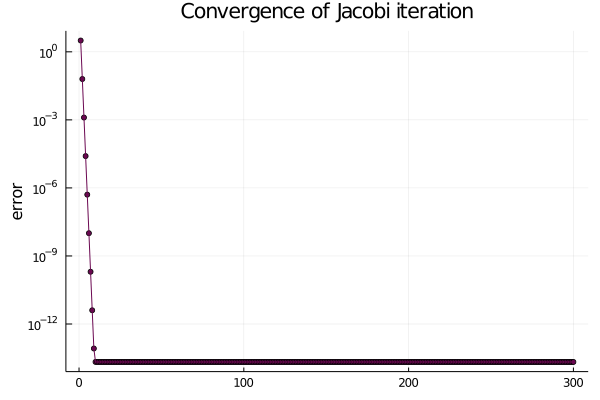

In [10]:
normres = jacobiGPU(300,25000)
scatter(normres, markersize=3, c="#6b0851", leg=false)
plot!(normres, color="#6b0851")
plot!(yaxis = ("error", :log10))
plot!(title="Convergence of Jacobi iteration")